## Install and import the required libraries

In [1]:
# pip install yfinance 

# yfinance is a python library which retrieves real time market value

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arch
import warnings
import requests

from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

register_matplotlib_converters()
warnings.filterwarnings("ignore")

## Loading Bitcoin value (BTC-USD)

In [27]:
import yfinance as yf

btc = yf.Ticker("BTC-USD")

# get stock info
print(btc.info)

# get historical market data
hist = btc.history(period="5d", interval = "1m")
df = hist.reset_index()
df

{'companyOfficers': [], 'name': 'Bitcoin', 'startDate': 1367107200, 'description': 'Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 18,721,987. The last known price of Bitcoin is 35,387.50455597 USD and is up 1.53 over the last 24 hours. It is currently trading on 9728 active market(s) with $42,723,213,076.31 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'maxAge': 1, 'previousClose': 35508.32, 'regularMarketOpen': 35508.32, 'twoHundredDayAverage': 40968.258, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': 30269378560, 'regularMarketDayHigh': 35843.113, 'navPrice': None, 'averageDailyVolume10Day': 62474051689, 'totalAssets': None, 'regularMarketPreviousClose': 35508.32, 'fiftyDayAverage': 51164.438, 'trailingAnnualDividendRate': None, 'open': 35508.32, 'toCurrency': 'USD=X', 'averageVolume10days': 62474051689, 'expireDate': None, 'yield': No

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-05-27 00:00:00+01:00,39019.730469,39019.730469,39019.730469,39019.730469,0,0,0
1,2021-05-27 00:01:00+01:00,38978.664062,38978.664062,38978.664062,38978.664062,0,0,0
2,2021-05-27 00:02:00+01:00,38937.027344,38937.027344,38937.027344,38937.027344,0,0,0
3,2021-05-27 00:03:00+01:00,38897.214844,38897.214844,38897.214844,38897.214844,0,0,0
4,2021-05-27 00:04:00+01:00,38783.230469,38783.230469,38783.230469,38783.230469,0,0,0
...,...,...,...,...,...,...,...,...
5748,2021-05-31 02:12:00+01:00,35337.312500,35337.312500,35337.312500,35337.312500,16482304,0,0
5749,2021-05-31 02:13:00+01:00,35348.550781,35348.550781,35348.550781,35348.550781,22609920,0,0
5750,2021-05-31 02:14:00+01:00,35296.222656,35296.222656,35296.222656,35296.222656,0,0,0
5751,2021-05-31 02:15:00+01:00,35272.035156,35272.035156,35272.035156,35272.035156,0,0,0


## Data Preprocessing 

In [28]:
# feature creation for better representation of price on a day
df['Mean'] = (df['Low'] + df['High'])/2

# remove NaNs and Nones
df=df.drop(columns=['Dividends','Stock Splits'])

# data preview
print(df.head())

                   Datetime          Open          High           Low  \
0 2021-05-27 00:00:00+01:00  39019.730469  39019.730469  39019.730469   
1 2021-05-27 00:01:00+01:00  38978.664062  38978.664062  38978.664062   
2 2021-05-27 00:02:00+01:00  38937.027344  38937.027344  38937.027344   
3 2021-05-27 00:03:00+01:00  38897.214844  38897.214844  38897.214844   
4 2021-05-27 00:04:00+01:00  38783.230469  38783.230469  38783.230469   

          Close  Volume          Mean  
0  39019.730469       0  39019.730469  
1  38978.664062       0  38978.664062  
2  38937.027344       0  38937.027344  
3  38897.214844       0  38897.214844  
4  38783.230469       0  38783.230469  


In [29]:
# Creating a copy for making small changes
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()

# date time typecast
dataset_for_prediction['Datetime'] =pd.to_datetime(dataset_for_prediction['Datetime'])
dataset_for_prediction.index= dataset_for_prediction['Datetime']

In [30]:
dataset_for_prediction

,Datetime,Open,High,Low,Close,Volume,Mean,Actual
Datetime,,,,,,,,
2021-05-27 00:00:00+01:00,2021-05-27 00:00:00+01:00,39019.730469,39019.730469,39019.730469,39019.730469,0,39019.730469,NaN
2021-05-27 00:01:00+01:00,2021-05-27 00:01:00+01:00,38978.664062,38978.664062,38978.664062,38978.664062,0,38978.664062,39019.730469
2021-05-27 00:02:00+01:00,2021-05-27 00:02:00+01:00,38937.027344,38937.027344,38937.027344,38937.027344,0,38937.027344,38978.664062
2021-05-27 00:03:00+01:00,2021-05-27 00:03:00+01:00,38897.214844,38897.214844,38897.214844,38897.214844,0,38897.214844,38937.027344
2021-05-27 00:04:00+01:00,2021-05-27 00:04:00+01:00,38783.230469,38783.230469,38783.230469,38783.230469,0,38783.230469,38897.214844
...,...,...,...,...,...,...,...,...
2021-05-31 02:12:00+01:00,2021-05-31 02:12:00+01:00,35337.312500,35337.312500,35337.312500,35337.312500,16482304,35337.312500,35315.906250
2021-05-31 02:13:00+01:00,2021-05-31 02:13:00+01:00,35348.550781,35348.550781,35348.550781,35348.550781,22609920,35348.550781,35337.312500
2021-05-31 02:14:00+01:00,2021-05-31 02:14:00+01:00,35296.222656,35296.222656,35296.222656,35296.222656,0,35296.222656,35348.550781


In [34]:
df_final = dataset_for_prediction[['Datetime', 'Actual']]
df_final = df_final.reset_index(drop=True)
df_final = df_final.dropna()

In [35]:
price = np.array(df_final['Actual'].tolist())

time = np.array(df_final['Datetime'].tolist())


In [37]:
price = price.reshape(5752,1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [38]:
scaler.fit(price[:1438])

price = scaler.transform(price)

df = pd.DataFrame(price.reshape(1438,4), columns = ['First', 'Second', 'Third', 'Target'])


In [39]:
df

,First,Second,Third,Target
0,0.248743,0.192680,0.135838,0.081487
1,-0.074122,-0.043592,0.022257,0.074683
2,0.169253,0.190696,0.217973,0.223151
3,0.124362,0.043321,0.103709,0.063484
4,0.059314,0.083306,0.163723,0.200045
...,...,...,...,...
1433,-4.700604,-4.724233,-4.683699,-4.704870
1434,-4.782573,-4.757632,-4.719695,-4.747484
1435,-4.734242,-4.659942,-4.726590,-4.790162
1436,-4.802880,-4.830024,-4.888673,-4.807642


## Creating the train-test data

In [40]:
# 75% train, 25% test

x_train = df.iloc[:360, :3]
y_train = df.iloc[:360, -1]

x_test = df.iloc[361:, :3]
y_test = df.iloc[361:, -1]

In [41]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [46]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## LSTM Model

In [50]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(40))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 20)             1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(x_train, y_train, batch_size=5, epochs = 100)

Epoch 1/100
72/72 [==============================] - 4s 3ms/step - loss: 0.8367
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 4/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 6/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 10/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 11/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 12/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 13/100
72/72 [=================

In [52]:
y_pred = model.predict(x_test)

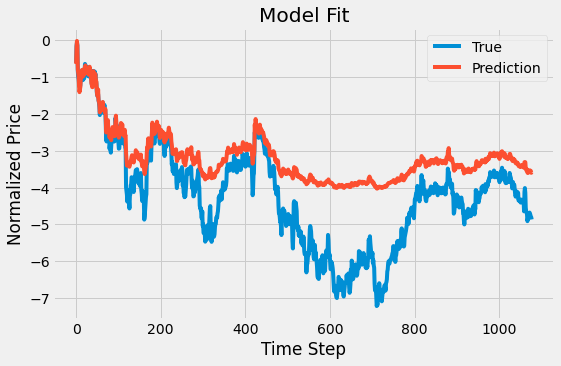

In [53]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()

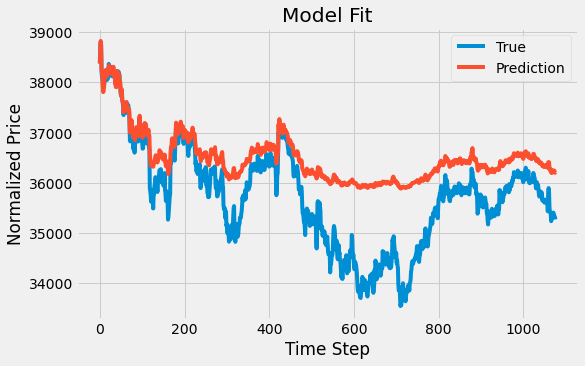

In [54]:
# we need to inverse tranform to check the original values, since we had scaled it previously

plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred), label='Prediction')
plt.legend()

In [55]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred)))
print ('Test Score {} RMSE'.format(testScore))

Test Score 943.0309762105401 RMSE
